# Sentiment Analysis Exercise  

The goal of the Sentiment Analysis (SA) task is to classify the sentiment within a piece of text. This sentiment can be either binary (positive-negative) or multi-class (a rating scale from 1 to 5).
 
Data: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz
 
Steps to Solve This Exercise
1. Load data into a pandas DataFrame
2. Preprocessing & Vectorizing 
3. Building Model
4. Evaluation

Note: Submit only a single Jupyter Notebook file that can handle all tasks, including data downloading, preprocessing, and model training. (Submissions that do not follow the guidelines will receive a score of 0.)

# Install and Import

In [32]:
%pip install gdown pandas numpy seaborn matplotlib scikit-learn nltk tqdm xgboost joblib wget

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
# Import libraries
import sys
import os
import platform
import gzip
import re
import joblib
import json
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

In [34]:
tqdm.pandas(desc="Processing text")

In [35]:
# ## Options
# pd.set_option("max_colwidth", None)

In [36]:
# Python environment details
print("Python executable being used:", sys.executable)
print("Python version:", sys.version)

# Operating System details
print("Operating System:", platform.system())
print("OS Version:", platform.version())
print("OS Release:", platform.release())

# Machine and architecture details
print("Machine:", platform.machine())

# Visual Studio Code details (based on environment variable)
vscode_info = os.environ.get('VSCODE_PID', None)
if vscode_info:
    print("Running in Visual Studio Code")
else:
    print("Not running in Visual Studio Code")

Python executable being used: c:\Python312\python.exe
Python version: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
Operating System: Windows
OS Version: 10.0.19045
OS Release: 10
Machine: AMD64
Running in Visual Studio Code


# Load data

In [37]:
# Download the dataset
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz"
filename = "reviews_Digital_Music_5.json.gz"

# Check if the file already exists
if not os.path.exists(filename):
    print("Downloading dataset...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print(f"Dataset downloaded and saved as {filename}")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
else:
    print(f"File already exists: {filename}")


File already exists: reviews_Digital_Music_5.json.gz


In [38]:
# Load JSON file
def load_data(file_path):
    data = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Load the dataset into a DataFrame
df = load_data(filename)

# Display basic info
print("\nDataset Sample:")
print(df.head())


Dataset Sample:
       reviewerID        asin          reviewerName helpful  \
0  A3EBHHCZO6V2A4  5555991584  Amaranth "music fan"  [3, 3]   
1   AZPWAXJG9OJXV  5555991584             bethtexas  [0, 0]   
2  A38IRL0X2T4DPF  5555991584           bob turnley  [2, 2]   
3  A22IK3I6U76GX0  5555991584                 Calle  [1, 1]   
4  A1AISPOIIHTHXX  5555991584           Cloud "..."  [1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

# Preprocess

In [39]:
df1 = df[['reviewText', 'overall']]
df1.head()

,reviewText,overall
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5.0
1,"A clasically-styled and introverted album, Memory of Trees is a masterpiece of subtlety. Many of the songs have an endearing shyness to them - soft piano and a lovely, quiet voice. But within every introvert is an inferno, and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power.If you've never heard Enya before, you might want to start with one of her more popularized works, like Watermark, just to play it safe. But if you're already a fan, then your collection is not complete without this beautiful work of musical art.",5.0
2,"I never thought Enya would reach the sublime heights of Evacuee or Marble Halls from 'Shepherd Moons.' 'The Celts, Watermark and Day...' were all pleasant and admirable throughout, but are less ambitious both lyrically and musically. But Hope Has a Place from 'Memory...' reaches those heights and beyond. It is Enya at her most inspirational and comforting. I'm actually glad that this song didn't get overexposed the way Only Time did. It makes it that much more special to all who own this album.",5.0
3,"This is the third review of an irish album I write today (the others were Cranberries) and now I'm sure about that Ireland is one of the countries producing the best music in the world. And not just commercial pop-music in the Spice Girls way. Okay, I just wanted to say something about Irish music. Now let's say something about this album. It's great. it's beautiful. Very good, easy listened music. If you like Enya or you just want some easy-listened relaxing music. This is the album for you to buy!",5.0
4,"Enya, despite being a successful recording artist, doesn't have the broad appeal as other artists; one reason might be that her kind of music is not very pop station friendly while another reason could be people think they're too ""macho"" for music that she makes. But people with open minds could find there's some beautiful melodies and harmonies as well as lively, upbeat tunes that are a joy to put on. I find the Memory of Trees to be one of her most consistent albums; plus it helps it has probably one of my top 5 favorite songs ever.The Memory of Trees: Like all of her records (except the recent Amarantine), the albums open with a wordless instrumental and this album's title track is probably my favorite with gentle piano arpeggios and a beautiful vocal track. I always like the sparse use of percussion. 9/10Anywhere Is: The lively single; it's actually a good sing-along with staccato beats and a great chorus. It's also a perfect length since it's under 3 minutes so whereas some pop songs drag after awhile, this one hooks you in then lets you go, leaving you wanting more. 9/10Pax Deorum: Another album, another ominous Latin-sung piece. The music sounds like something you'd hear in enemy territories in video games while Enya gives a low-voice, almost monotone performance over the music. Slightly repetitive until a 2nd higher voice comes in but the piece hits its stride halfwa

In [40]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64706 entries, 0 to 64705
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  64706 non-null  object 
 1   overall     64706 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1011.2+ KB


In [41]:
df1['overall'].unique()

array([5., 4., 3., 1., 2.])

In [42]:
value_counts = df1['overall'].value_counts()
print(value_counts)

overall
5.0    35580
4.0    16536
3.0     6789
2.0     3010
1.0     2791
Name: count, dtype: int64


In [43]:
# Convert ratings to binary sentiment (1-3 = negative, 4-5 = positive)
df1['sentiment'] = df1['overall'].apply(lambda x: 1 if x > 3 else 0)


C:\Users\User\AppData\Local\Temp\ipykernel_19632\3116498781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['sentiment'] = df1['overall'].apply(lambda x: 1 if x > 3 else 0)


In [44]:
value_counts = df1['sentiment'].value_counts()
print(value_counts)

sentiment
1    52116
0    12590
Name: count, dtype: int64


In [45]:
# Convert ratings to binary sentiment (1-3 = negative, 4-5 = positive)
df1.head()

,reviewText,overall,sentiment
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5.0,1
1,"A clasically-styled and introverted album, Memory of Trees is a masterpiece of subtlety. Many of the songs have an endearing shyness to them - soft piano and a lovely, quiet voice. But within every introvert is an inferno, and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power.If you've never heard Enya before, you might want to start with one of her more popularized works, like Watermark, just to play it safe. But if you're already a fan, then your collection is not complete without this beautiful work of musical art.",5.0,1
2,"I never thought Enya would reach the sublime heights of Evacuee or Marble Halls from 'Shepherd Moons.' 'The Celts, Watermark and Day...' were all pleasant and admirable throughout, but are less ambitious both lyrically and musically. But Hope Has a Place from 'Memory...' reaches those heights and beyond. It is Enya at her most inspirational and comforting. I'm actually glad that this song didn't get overexposed the way Only Time did. It makes it that much more special to all who own this album.",5.0,1
3,"This is the third review of an irish album I write today (the others were Cranberries) and now I'm sure about that Ireland is one of the countries producing the best music in the world. And not just commercial pop-music in the Spice Girls way. Okay, I just wanted to say something about Irish music. Now let's say something about this album. It's great. it's beautiful. Very good, easy listened music. If you like Enya or you just want some easy-listened relaxing music. This is the album for you to buy!",5.0,1
4,"Enya, despite being a successful recording artist, doesn't have the broad appeal as other artists; one reason might be that her kind of music is not very pop station friendly while another reason could be people think they're too ""macho"" for music that she makes. But people with open minds could find there's some beautiful melodies and harmonies as well as lively, upbeat tunes that are a joy to put on. I find the Memory of Trees to be one of her most consistent albums; plus it helps it has probably one of my top 5 favorite songs ever.The Memory of Trees: Like all of her records (except the recent Amarantine), the albums open with a wordless instrumental and this album's title track is probably my favorite with gentle piano arpeggios and a beautiful vocal track. I always like the sparse use of percussion. 9/10Anywhere Is: The lively single; it's actually a good sing-along with staccato beats and a great chorus. It's also a perfect length since it's under 3 minutes so whereas some pop songs drag after awhile, this one hooks you in then lets you go, leaving you wanting more. 9/10Pax Deorum: Another album, another ominous Latin-sung piece. The music sounds like something you'd hear in enemy territories in video games while Enya gives a low-voice, almost monotone performance over the music. Slightly repetitive until a 2nd higher voice comes in but the piece hits

In [46]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64706 entries, 0 to 64705
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  64706 non-null  object 
 1   overall     64706 non-null  float64
 2   sentiment   64706 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [48]:
df1.head()

,reviewText,overall,sentiment
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5.0,1
1,"A clasically-styled and introverted album, Memory of Trees is a masterpiece of subtlety. Many of the songs have an endearing shyness to them - soft piano and a lovely, quiet voice. But within every introvert is an inferno, and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power.If you've never heard Enya before, you might want to start with one of her more popularized works, like Watermark, just to play it safe. But if you're already a fan, then your collection is not complete without this beautiful work of musical art.",5.0,1
2,"I never thought Enya would reach the sublime heights of Evacuee or Marble Halls from 'Shepherd Moons.' 'The Celts, Watermark and Day...' were all pleasant and admirable throughout, but are less ambitious both lyrically and musically. But Hope Has a Place from 'Memory...' reaches those heights and beyond. It is Enya at her most inspirational and comforting. I'm actually glad that this song didn't get overexposed the way Only Time did. It makes it that much more special to all who own this album.",5.0,1
3,"This is the third review of an irish album I write today (the others were Cranberries) and now I'm sure about that Ireland is one of the countries producing the best music in the world. And not just commercial pop-music in the Spice Girls way. Okay, I just wanted to say something about Irish music. Now let's say something about this album. It's great. it's beautiful. Very good, easy listened music. If you like Enya or you just want some easy-listened relaxing music. This is the album for you to buy!",5.0,1
4,"Enya, despite being a successful recording artist, doesn't have the broad appeal as other artists; one reason might be that her kind of music is not very pop station friendly while another reason could be people think they're too ""macho"" for music that she makes. But people with open minds could find there's some beautiful melodies and harmonies as well as lively, upbeat tunes that are a joy to put on. I find the Memory of Trees to be one of her most consistent albums; plus it helps it has probably one of my top 5 favorite songs ever.The Memory of Trees: Like all of her records (except the recent Amarantine), the albums open with a wordless instrumental and this album's title track is probably my favorite with gentle piano arpeggios and a beautiful vocal track. I always like the sparse use of percussion. 9/10Anywhere Is: The lively single; it's actually a good sing-along with staccato beats and a great chorus. It's also a perfect length since it's under 3 minutes so whereas some pop songs drag after awhile, this one hooks you in then lets you go, leaving you wanting more. 9/10Pax Deorum: Another album, another ominous Latin-sung piece. The music sounds like something you'd hear in enemy territories in video games while Enya gives a low-voice, almost monotone performance over the music. Slightly repetitive until a 2nd higher voice comes in but the piece hits

In [49]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64706 entries, 0 to 64705
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  64706 non-null  object 
 1   overall     64706 non-null  float64
 2   sentiment   64706 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.5+ MB


# Vectorizer

In [50]:
# Adjust overall ratings to start from 0
df1['overall'] = df1['overall'] - 1  # Shifts [1,2,3,4,5] -> [0,1,2,3,4]


In [51]:
df1.head()

,reviewText,overall,sentiment
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",4.0,1
1,"A clasically-styled and introverted album, Memory of Trees is a masterpiece of subtlety. Many of the songs have an endearing shyness to them - soft piano and a lovely, quiet voice. But within every introvert is an inferno, and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power.If you've never heard Enya before, you might want to start with one of her more popularized works, like Watermark, just to play it safe. But if you're already a fan, then your collection is not complete without this beautiful work of musical art.",4.0,1
2,"I never thought Enya would reach the sublime heights of Evacuee or Marble Halls from 'Shepherd Moons.' 'The Celts, Watermark and Day...' were all pleasant and admirable throughout, but are less ambitious both lyrically and musically. But Hope Has a Place from 'Memory...' reaches those heights and beyond. It is Enya at her most inspirational and comforting. I'm actually glad that this song didn't get overexposed the way Only Time did. It makes it that much more special to all who own this album.",4.0,1
3,"This is the third review of an irish album I write today (the others were Cranberries) and now I'm sure about that Ireland is one of the countries producing the best music in the world. And not just commercial pop-music in the Spice Girls way. Okay, I just wanted to say something about Irish music. Now let's say something about this album. It's great. it's beautiful. Very good, easy listened music. If you like Enya or you just want some easy-listened relaxing music. This is the album for you to buy!",4.0,1
4,"Enya, despite being a successful recording artist, doesn't have the broad appeal as other artists; one reason might be that her kind of music is not very pop station friendly while another reason could be people think they're too ""macho"" for music that she makes. But people with open minds could find there's some beautiful melodies and harmonies as well as lively, upbeat tunes that are a joy to put on. I find the Memory of Trees to be one of her most consistent albums; plus it helps it has probably one of my top 5 favorite songs ever.The Memory of Trees: Like all of her records (except the recent Amarantine), the albums open with a wordless instrumental and this album's title track is probably my favorite with gentle piano arpeggios and a beautiful vocal track. I always like the sparse use of percussion. 9/10Anywhere Is: The lively single; it's actually a good sing-along with staccato beats and a great chorus. It's also a perfect length since it's under 3 minutes so whereas some pop songs drag after awhile, this one hooks you in then lets you go, leaving you wanting more. 9/10Pax Deorum: Another album, another ominous Latin-sung piece. The music sounds like something you'd hear in enemy territories in video games while Enya gives a low-voice, almost monotone performance over the music. Slightly repetitive until a 2nd higher voice comes in but the piece hits

In [52]:
# # Save DataFrame to CSV
# csv_save_path = "df1.csv"
# df1.to_csv(csv_save_path, index=False)

# print(f"✅ Results saved to {csv_save_path}")

In [53]:
# df1 = pd.read_csv("df1.csv")
# df1.head()

In [54]:
# df1.info()

In [55]:
# df_cleaned = df1.dropna(subset=['reviewText'])
# print(df_cleaned.info())
# df1 = df_cleaned

In [60]:
# Rename 'text' to 'reviewText' safely
df1 = df1.rename(columns={"reviewText": "text"})

In [62]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64706 entries, 0 to 64705
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       64706 non-null  object 
 1   overall    64706 non-null  float64
 2   sentiment  64706 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [63]:
# Step 1: Train-Test Split for `overall` prediction
X_train, X_test, y_train_overall, y_test_overall = train_test_split(
    df1['text'], df1['overall'], test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train_overall.shape)
print("y_test shape:", y_test_overall.shape)

X_train shape: (51764,)
X_test shape: (12942,)
y_train shape: (51764,)
y_test shape: (12942,)


In [64]:
# Step 2: Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)

X_train_tfidf shape: (51764, 5000)
X_test_tfidf shape: (12942, 5000)


# Build Model

I have read here on the link and get the information about models used for multiclass classification and then i try to run all of them

https://scikit-learn.org/stable/modules/multiclass.html

In [65]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid, RadiusNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, RidgeClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np
from scipy.sparse import issparse

# Define models for multiclass classification
models_overall = {
    "BernoulliNB": BernoulliNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=10, random_state=42),
    "ExtraTreeClassifier": ExtraTreeClassifier(max_depth=10, random_state=42),
    "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=100, max_depth=10, max_features="sqrt", random_state=42),
    "GaussianNB": GaussianNB(var_smoothing=1e-9),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=5, leaf_size=30),
    # "LabelPropagation": LabelPropagation(n_neighbors=5, tol=1e-3, kernel="knn"),      # so long
    # "LabelSpreading": LabelSpreading(n_neighbors=5, tol=1e-3, kernel="knn"),          # maybe like above
    # "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(tol=1e-3),               # so long
    "LinearSVC": LinearSVC(multi_class="crammer_singer", max_iter=500, tol=1e-3, dual=False, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=500, solver="saga", tol=1e-3, random_state=42),
    # "LogisticRegressionCV": LogisticRegressionCV(max_iter=500, solver="saga", tol=1e-3, random_state=42),  # so long
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, learning_rate_init=0.01, early_stopping=True, random_state=42),
    "NearestCentroid": NearestCentroid(),
    # "QuadraticDiscriminantAnalysis": QuadraticDiscriminantAnalysis(tol=1e-3, reg_param=0.1), # so long
    "RidgeClassifier": RidgeClassifier(),
    # "RidgeClassifierCV": RidgeClassifierCV(), - ok but 5mins / fold
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, max_depth=10, max_features="sqrt", random_state=42)
}

# Step 4: Train and evaluate models for `overall` prediction
results_overall = {}
best_model_overall = None
best_accuracy = 0

trained_models = {}  # Store trained models

for model_name, model in models_overall.items():
    print(f"Training and evaluating {model_name}...")

    # K-Fold Cross-Validation
    accuracy_scores, roc_auc_scores, f1_scores = [], [], []
    k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in tqdm(k_fold.split(X_train_tfidf), total=k_fold.get_n_splits(), desc="K-Fold Progress"):
        X_train, X_val = X_train_tfidf[train_index], X_train_tfidf[val_index]
        y_train, y_val = y_train_overall.iloc[train_index], y_train_overall.iloc[val_index]

        # Convert to dense format ONLY for models that require it
        if isinstance(model, (GaussianNB, LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis, MLPClassifier, NearestCentroid)):
            if issparse(X_train):  # Check if it's sparse
                X_train = X_train.toarray()
                X_val = X_val.toarray()

        # Scale data ONLY for distance-based models
        if isinstance(model, (RadiusNeighborsClassifier, KNeighborsClassifier)):
            scaler = StandardScaler(with_mean=False) # handle sparse matrix
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)

        accuracy_scores.append(accuracy_score(y_val, val_preds))
        
        if hasattr(model, "predict_proba"):  
            val_probs = model.predict_proba(X_val)
            # roc_auc = roc_auc_score(y_val, val_probs, multi_class='ovr')
            # Skip ROC AUC calculation if probabilities don't sum to 1
            if not np.allclose(1, val_probs.sum(axis=1)):
                print(f"⚠️ Skipping ROC AUC for {model_name} due to invalid probabilities.")
                roc_auc = None
            else:
                roc_auc = roc_auc_score(y_val, val_probs, multi_class='ovr')
        else:
            roc_auc = None  

        f1_scores.append(f1_score(y_val, val_preds, average='weighted'))
        if roc_auc is not None:
            roc_auc_scores.append(roc_auc)

    # Compute average scores
    avg_acc = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    avg_roc_auc = np.mean(roc_auc_scores) if roc_auc_scores else None

    # Store trained model
    trained_models[model_name] = model  # ✅ Save trained model
    results_overall[model_name] = {
        "Accuracy": avg_acc,
        "F1 Score": avg_f1,
        "ROC AUC": avg_roc_auc,
        "Accuracy Scores": accuracy_scores,
        "F1 Scores": f1_scores,
        "ROC AUC Scores": roc_auc_scores
    }

    # Update Best Model
    if avg_acc > best_accuracy:
        best_accuracy = avg_acc
        best_model_overall = model_name

print(f"\n🏆 Best Model: {best_model_overall} with Accuracy: {best_accuracy:.3f}")

Training and evaluating BernoulliNB...


K-Fold Progress: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


Training and evaluating DecisionTreeClassifier...


K-Fold Progress: 100%|██████████| 5/5 [02:02<00:00, 24.56s/it]


Training and evaluating ExtraTreeClassifier...


K-Fold Progress: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Training and evaluating ExtraTreesClassifier...


K-Fold Progress: 100%|██████████| 5/5 [00:48<00:00,  9.76s/it]


Training and evaluating GaussianNB...


K-Fold Progress: 100%|██████████| 5/5 [02:02<00:00, 24.41s/it]


Training and evaluating KNeighborsClassifier...


K-Fold Progress: 100%|██████████| 5/5 [11:02<00:00, 132.56s/it]


Training and evaluating LinearSVC...


K-Fold Progress:   0%|          | 0/5 [00:00<?, ?it/s]c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
K-Fold Progress:  20%|██        | 1/5 [00:08<00:35,  8.76s/it]c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
K-Fold Progress:  40%|████      | 2/5 [00:15<00:22,  7.65s/it]c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
K-Fold Progress:  60%|██████    | 3/5 [00:22<00:14,  7.47s/it]c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
K-Fold Progress:  80%|████████  | 4/5 [00:41<00:11, 11.67s/it]c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: 

Training and evaluating LogisticRegression...


K-Fold Progress: 100%|██████████| 5/5 [00:25<00:00,  5.08s/it]


Training and evaluating MLPClassifier...


K-Fold Progress: 100%|██████████| 5/5 [06:10<00:00, 74.11s/it]


Training and evaluating NearestCentroid...


K-Fold Progress: 100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


Training and evaluating RidgeClassifier...


K-Fold Progress: 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]


Training and evaluating RandomForestClassifier...


K-Fold Progress: 100%|██████████| 5/5 [01:46<00:00, 21.36s/it]



🏆 Best Model: MLPClassifier with Accuracy: 0.640


# Evaluate the model

Result of Training and evaluating BernoulliNB...
📊 BernoulliNB - Average Accuracy: 0.347
Result of Training and evaluating DecisionTreeClassifier...
📊 DecisionTreeClassifier - Average Accuracy: 0.559
Result of Training and evaluating ExtraTreeClassifier...
📊 ExtraTreeClassifier - Average Accuracy: 0.549
Result of Training and evaluating ExtraTreesClassifier...
📊 ExtraTreesClassifier - Average Accuracy: 0.549
Result of Training and evaluating GaussianNB...
📊 GaussianNB - Average Accuracy: 0.316
Result of Training and evaluating KNeighborsClassifier...
📊 KNeighborsClassifier - Average Accuracy: 0.461
Result of Training and evaluating LinearSVC...
📊 LinearSVC - Average Accuracy: 0.626
Result of Training and evaluating LogisticRegression...
📊 LogisticRegression - Average Accuracy: 0.637
Result of Training and evaluating MLPClassifier...
📊 MLPClassifier - Average Accuracy: 0.640
Result of Training and evaluating NearestCentroid...
📊 NearestCentroid - Average Accuracy: 0.382
Result of Traini

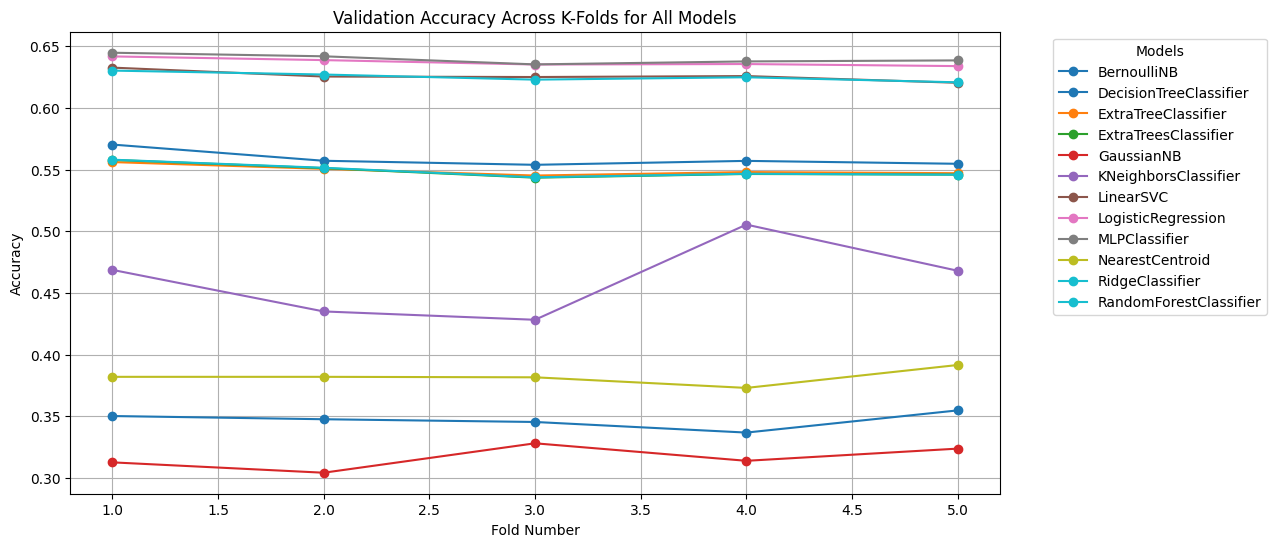

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Define color map for different models
num_models = len(models_overall)
colors = plt.cm.tab10(np.linspace(0, 1, num_models))  # Generate unique colors

# Create a figure for Accuracy
plt.figure(figsize=(12, 6))
plt.title("Validation Accuracy Across K-Folds for All Models")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.grid(True)

# Iterate over each model and assign a unique color for Accuracy
for idx, (model_name, model) in enumerate(models_overall.items()):
    color = colors[idx]

    # Print evaluation results
    print(f"Result of Training and evaluating {model_name}...")
    print(f'📊 {model_name} - Average Accuracy: {results_overall[model_name]["Accuracy"]:.3f}')

    # Plot Accuracy
    plt.plot(range(1, len(results_overall[model_name]["Accuracy Scores"]) + 1), 
             results_overall[model_name]["Accuracy Scores"], 
             label=f"{model_name}", marker='o', linestyle='-', color=color)

# Add legend and show Accuracy plot
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


📊 BernoulliNB - Average ROC AUC: 0.678
📊 DecisionTreeClassifier - Average ROC AUC: 0.640
📊 ExtraTreeClassifier - Average ROC AUC: 0.583
📊 ExtraTreesClassifier - Average ROC AUC: 0.781
📊 GaussianNB - Average ROC AUC: 0.596
📊 KNeighborsClassifier - Average ROC AUC: 0.544
📊 LinearSVC - Average ROC AUC: N/A
📊 LogisticRegression - Average ROC AUC: 0.848
📊 MLPClassifier - Average ROC AUC: 0.850
📊 NearestCentroid - Average ROC AUC: N/A
📊 RidgeClassifier - Average ROC AUC: N/A
📊 RandomForestClassifier - Average ROC AUC: 0.782


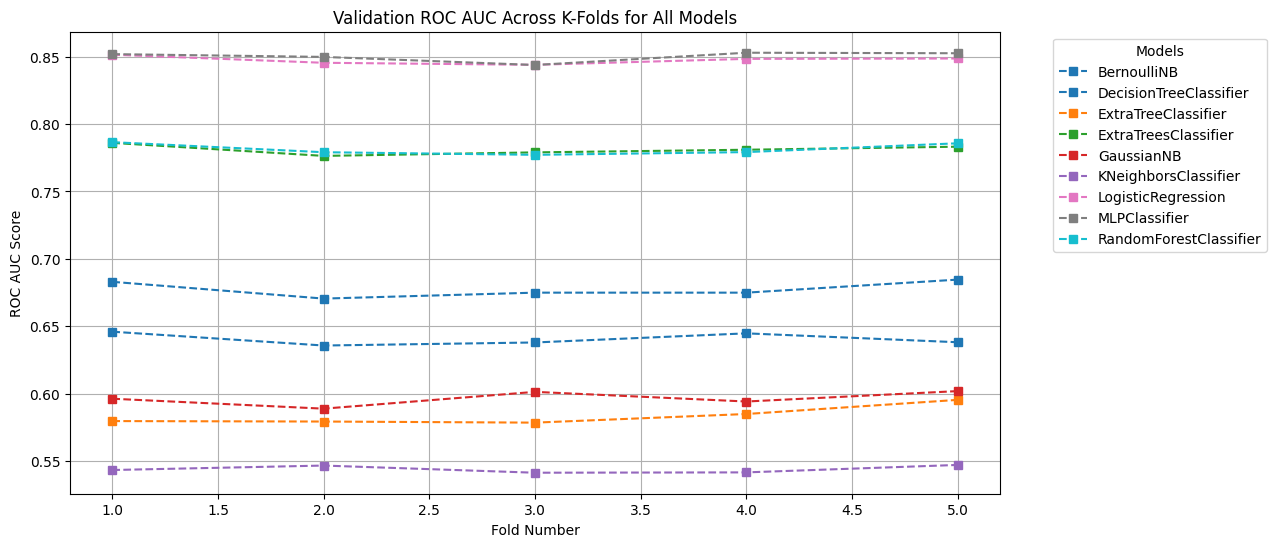


🏆 Best Model: MLPClassifier with Accuracy: 0.640


In [67]:
# ---------------------- ROC AUC PLOT ----------------------

# Create a figure for ROC AUC
plt.figure(figsize=(12, 6))
plt.title("Validation ROC AUC Across K-Folds for All Models")
plt.xlabel("Fold Number")
plt.ylabel("ROC AUC Score")
plt.grid(True)

# Iterate over models again for ROC AUC
for idx, (model_name, model) in enumerate(models_overall.items()):
    color = colors[idx]
    
    # Handle ROC AUC None values
    roc_auc = results_overall[model_name]["ROC AUC"]
    roc_auc_str = f"{roc_auc:.3f}" if roc_auc is not None else "N/A"
    print(f'📊 {model_name} - Average ROC AUC: {roc_auc_str}')
    
    # Plot ROC AUC only if it exists
    if results_overall[model_name]["ROC AUC Scores"]:
        plt.plot(range(1, len(results_overall[model_name]["ROC AUC Scores"]) + 1), 
                 results_overall[model_name]["ROC AUC Scores"], 
                 label=f"{model_name}", marker='s', linestyle='--', color=color)

# Add legend and show ROC AUC plot
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Print the best model
print(f"\n🏆 Best Model: {best_model_overall} with Accuracy: {best_accuracy:.3f}")


In [68]:
# ✅ Use the trained models to test on X_test_tfidf
test_results = {}

for model_name, model in trained_models.items():
    print(f"\n🔍 Testing {model_name} on Test Data...")

    # Convert to dense format ONLY for models that require it
    if isinstance(model, (GaussianNB, LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis, MLPClassifier, NearestCentroid)):
        if issparse(X_test_tfidf):  # Check if sparse
            X_test_tfidf = X_test_tfidf.toarray()

    # Scale data ONLY for distance-based models
    if isinstance(model, (RadiusNeighborsClassifier, KNeighborsClassifier)):
        scaler = StandardScaler()
        X_test_tfidf = scaler.fit_transform(X_test_tfidf)

    # Make Predictions
    y_test_pred = model.predict(X_test_tfidf)

    # Compute Metrics
    test_accuracy = accuracy_score(y_test_overall, y_test_pred)
    test_f1 = f1_score(y_test_overall, y_test_pred, average='weighted')
    
    if hasattr(model, "predict_proba"):
        y_test_probs = model.predict_proba(X_test_tfidf)
        test_roc_auc = roc_auc_score(y_test_overall, y_test_probs, multi_class='ovr')
    else:
        test_roc_auc = None  # Skip if model does not support probability prediction
    
    # Store Results
    test_results[model_name] = {
        "Test Accuracy": test_accuracy,
        "Test F1 Score": test_f1,
        "Test ROC AUC": test_roc_auc if test_roc_auc else "N/A"
    }
    
    print(f"📊 {model_name} - Test Accuracy: {test_accuracy:.3f}, Test F1 Score: {test_f1:.3f}")



🔍 Testing BernoulliNB on Test Data...
📊 BernoulliNB - Test Accuracy: 0.354, Test F1 Score: 0.398

🔍 Testing DecisionTreeClassifier on Test Data...
📊 DecisionTreeClassifier - Test Accuracy: 0.555, Test F1 Score: 0.489

🔍 Testing ExtraTreeClassifier on Test Data...
📊 ExtraTreeClassifier - Test Accuracy: 0.552, Test F1 Score: 0.411

🔍 Testing ExtraTreesClassifier on Test Data...
📊 ExtraTreesClassifier - Test Accuracy: 0.554, Test F1 Score: 0.395

🔍 Testing GaussianNB on Test Data...
📊 GaussianNB - Test Accuracy: 0.324, Test F1 Score: 0.378

🔍 Testing KNeighborsClassifier on Test Data...
📊 KNeighborsClassifier - Test Accuracy: 0.516, Test F1 Score: 0.455

🔍 Testing LinearSVC on Test Data...
📊 LinearSVC - Test Accuracy: 0.451, Test F1 Score: 0.490

🔍 Testing LogisticRegression on Test Data...
📊 LogisticRegression - Test Accuracy: 0.468, Test F1 Score: 0.505

🔍 Testing MLPClassifier on Test Data...
📊 MLPClassifier - Test Accuracy: 0.503, Test F1 Score: 0.525

🔍 Testing NearestCentroid on Te